In [36]:
from sklearn import mixture, cluster
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sympy import *

In [39]:
from ipywidgets import interact
from IPython.display import display, Markdown, Latex

In [4]:
warnings.filterwarnings('ignore')

### Cok degiskenli Gaussian dagilim

In [54]:
@interact
def gaussviz(
    sigma11=(.1, 2., .1),
    sigma12=(-2., 2., .1),
    sigma22=(.1, 2., .1),
    ):
    mu1 = [0, 0]
    Sigma1 = [[sigma11, sigma12], [sigma12, sigma22]]
    if np.linalg.det(Sigma1) == 0:
        plt.scatter(*np.random.randn(100,2).T, color='gray', alpha=0.6)
        plt.title('Kovaryans matrisi $\Sigma$ tersi alinabilir olmalidir.')
        plt.text(-4, -1, "W A S T E D", color='red', fontsize=50)
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        return
    if (np.linalg.eigvals(Sigma1) < 0).any():
        plt.scatter(*np.random.randn(100,2).T, color='gray', alpha=0.6)
        plt.text(-4, -1, "W A S T E D", color='red', fontsize=50)
        plt.title('Kovaryans matrisi $\Sigma$ pozitif yari-tanimli olmalidir.')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        return
    dist = scs.multivariate_normal(mu1, Sigma1)
    x = dist.rvs(10000)
    pdf = dist.pdf(x)
    plt.scatter(x[:, 0], x[:, 1], c=pdf, cmap='jet', s=10)
    plt.colorbar().set_label("$log\ pdf$")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.grid()

interactive(children=(FloatSlider(value=1.0, description='sigma11', max=2.0, min=0.1), FloatSlider(value=0.0, …

Yukaridaki interaktif hucreyle yeteri kadar oynadiysaniz kovaryans matrisi icin gereken sartlari artik biliyorsunuz.

Sentetik dataset uretici parametrelerimiz:

In [55]:
mu1 = [0, 0]
Sigma1 = [[5., -4.], [-4., 5.]]

mu2 = [-9., -9.]
Sigma2 = [[3.0, 2.8], [2.8, 3.0]]

In [56]:
np.linalg.eig(Sigma1)[0].__ge__(0).all()

True

In [57]:
np.linalg.eig(Sigma2)[0].__ge__(0).all()

True

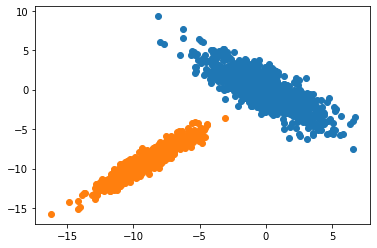

In [60]:
d1 = scs.multivariate_normal([0, 0], cov=Sigma1)
d2 = scs.multivariate_normal([-9, -9], cov=Sigma2)
plt.scatter(*d1.rvs(1000, 2).T)
plt.scatter(*d2.rvs(1000, 2).T);


In [61]:
def plot_model(model, ind, xx, yy):
    xyravel = np.array([xx.ravel(), yy.ravel()]).T
    zz = scs.multivariate_normal(model.means_[ind], model.covariances_[ind]).pdf(xyravel).reshape(xx.shape)
    zz[zz <= 1e-3] = np.nan
    plt.contourf(xx, yy, zz, alpha=0.3)
    
def plot_dist(mean, cov, xx, yy):
    xyravel = np.array([xx.ravel(), yy.ravel()]).T
    zz = scs.multivariate_normal(mean, cov).pdf(xyravel).reshape(xx.shape)
    zz[zz <= 1e-3] = np.nan
    plt.contourf(xx, yy, zz, alpha=0.3)

In [62]:
X = d1.rvs(1000, 2).tolist() + d2.rvs(1000, 2).tolist()
X = np.array(X)
y = [0] * 1000 + [1] * 1000

initial_means = np.array([[0, 0], [0, 5]])
initial_precisions =np.array( [[[1, 0], [0, 1]], [[5,2],[2,5]]])

xx, yy = np.meshgrid(np.linspace(-16, 6, 100), np.linspace(-16, 11, 100))

In [64]:
@interact(iters=(0,40,1))
def vizgmm(iters=0):
    m = mixture.GaussianMixture(n_components=2, max_iter=iters, init_params='random', 
                                means_init=initial_means, 
                                precisions_init=initial_precisions, 
                                covariance_type='full')

    m._initialize_parameters(X, np.random.RandomState())
    plt.figure(figsize=(12, 8))
    if not iters:
        plt.title("Baslangic parametreleri")
        plot_dist(initial_means[0], np.linalg.inv(initial_precisions[0]), xx, yy)
        plot_dist(initial_means[1], np.linalg.inv(initial_precisions[1]), xx, yy)
        plt.colorbar().set_label('PDF')
        plt.scatter(*X.T, c=m.predict(X), alpha=0.7, edgecolors='k')
        return
    else:
        
        ln, ls = m._e_step(X)
        m._m_step(X, ls)

    
    for _ in range(iters):
        if not _ % 2:
            plt.title(f"Iterasyon {iters//2}: E adimi")
            ln, ls = m._e_step(X)
        else:
            plt.title(f"Iterasyon {iters//2}: M adimi")
            ln, ls = m._estimate_log_prob_resp(X)
            m._m_step(X, ls)

    plot_model(m, 0, xx, yy)
    plot_model(m, 1, xx, yy)        
    plt.colorbar().set_label('PDF')
    plt.scatter(*X.T, c=ls.argmax(axis=1), alpha=0.7, edgecolors='k')
    plt.grid()



interactive(children=(IntSlider(value=0, description='iters', max=40), Output()), _dom_classes=('widget-intera…

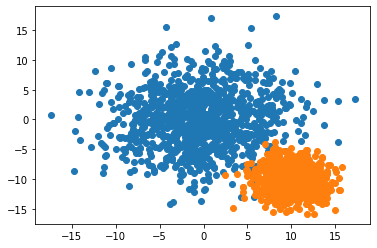

In [65]:
e1 = scs.norm([0, 0], [5, 5])
e2 = scs.norm([10, -10], [2, 2])
plt.scatter(*e1.rvs((1000, 2)).T)
plt.scatter(*e2.rvs((1000, 2)).T)
X2 = e1.rvs((1000, 2)).tolist() + e2.rvs((1000, 2)).tolist()
X2 = np.array(X2)

In [66]:
xx, yy = np.meshgrid(np.linspace(-15, 25, 100), np.linspace(-20, 20, 100))

In [70]:
@interact(iters=(0,40,1))
def vizgmm(iters=0):
    global m
    m = mixture.GaussianMixture(n_components=2, max_iter=iters, init_params='random', 
                                means_init=initial_means, 
                                precisions_init=initial_precisions)

    m._initialize_parameters(X2, np.random.RandomState())
    plt.figure(figsize=(12, 8))
    if not iters:
        plt.title("Baslangic parametreleri (rassal)")
        plot_dist(initial_means[0], np.linalg.inv(initial_precisions[0]), xx, yy)
        plot_dist(initial_means[1], np.linalg.inv(initial_precisions[1]), xx, yy)
        plt.colorbar().set_label('PDF')
        plt.scatter(*X2.T, c=m.predict(X), alpha=0.7, edgecolors='k', cmap="rainbow")
        return

    for _ in range(iters):
            ln, ls = m._e_step(X2)
            m._m_step(X2, ls)

    plt.title(f"Iterasyon {iters}")
    plot_model(m, 0, xx, yy)
    plot_model(m, 1, xx, yy)        
    plt.colorbar().set_label('PDF')
    plt.scatter(*X2.T, c=ls.argmax(axis=1), alpha=0.7, edgecolors='k', cmap='rainbow')



interactive(children=(IntSlider(value=0, description='iters', max=40), Output()), _dom_classes=('widget-intera…

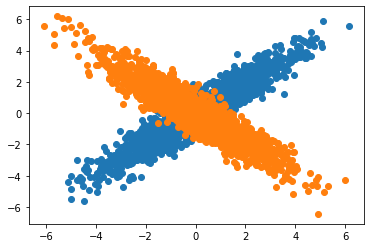

In [33]:
initial_means = np.array([[0, 0], [0, 0]])
initial_precisions =np.array( [[[1, 0], [0, 1]], [[5,2],[2,5]]])
e1 = scs.multivariate_normal([0, 0], [[3, 2.8], [2.8, 3]])
e2 = scs.multivariate_normal([0, 0], [[3, -2.8], [-2.8, 3]])
plt.scatter(*e1.rvs((1000, 2)).T)
plt.scatter(*e2.rvs((1000, 2)).T)
X2 = e1.rvs(1000, 2).tolist() + e2.rvs(1000, 2).tolist()
X2 = np.array(X2)
xx, yy = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))

In [72]:
@interact(iters=(0,40,1))
def vizgmm(iters=0):
    global m
    m = mixture.GaussianMixture(n_components=2, max_iter=iters, init_params='random', 
                                means_init=initial_means, 
                                precisions_init=initial_precisions)

    m._initialize_parameters(X2, np.random.RandomState())
    plt.figure(figsize=(12, 8))
    if not iters:
        plt.title("Baslangic parametreleri (rassal)")
        plot_dist(initial_means[0], np.linalg.inv(initial_precisions[0]), xx, yy)
        plot_dist(initial_means[1], np.linalg.inv(initial_precisions[1]), xx, yy)
        plt.colorbar().set_label('PDF')
        plt.scatter(*X2.T, c=m.predict(X), alpha=0.7, edgecolors='k', cmap="rainbow")
        return

    for _ in range(iters):
        ln, ls = m._e_step(X2)
        m._m_step(X2, ls)

    plt.title(f"Iterasyon {iters}")
    plot_model(m, 0, xx, yy)
    plot_model(m, 1, xx, yy)        
    plt.colorbar().set_label('PDF')
    plt.scatter(*X2.T, c=m.predict(X2), alpha=0.7, edgecolors='k', cmap="rainbow")



interactive(children=(IntSlider(value=0, description='iters', max=40), Output()), _dom_classes=('widget-intera…

## Bulunan parametrelerin kalitesi: log-likelihood

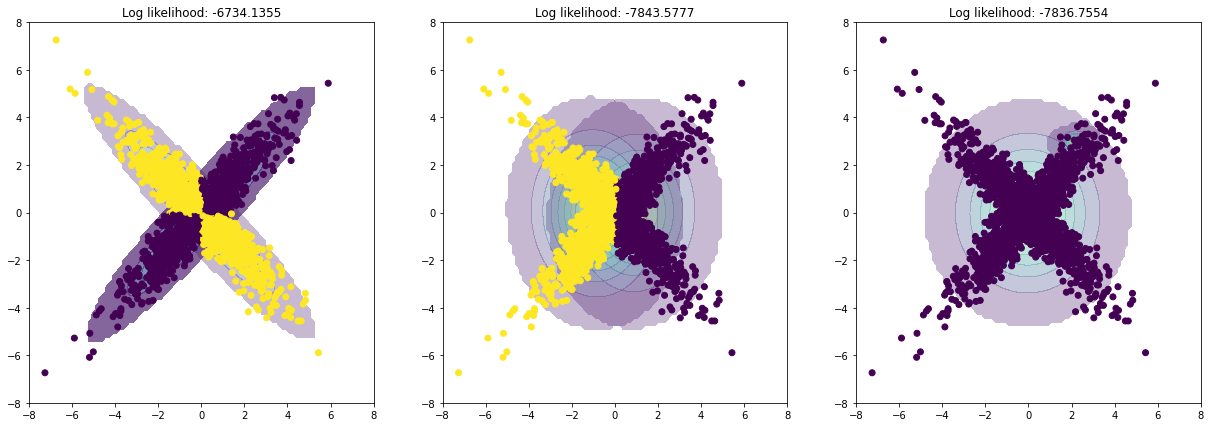

In [35]:
initial_means = np.array([[0, 5], [0, 5]])
initial_precisions =np.array( [[[1, 0], [0, 1]], [[5,2],[2,5]]])
plt.figure(figsize=(21,7))
states = [12, 12, 76]
for i in range(1, 4):
    plt.subplot(1, 3, i)
    if i == 1:
        gmm = mixture.GaussianMixture(n_components=2, init_params='random', random_state=states[i-1], n_init=1, max_iter=10000)
        gmm.fit(X2)
        plot_model(gmm, 0, xx, yy)
        plot_model(gmm, 0, xx, yy)
    elif i== 2:
        gmm = mixture.GaussianMixture(n_components=2, init_params='kmeans', random_state=states[i-1], n_init=1, max_iter=10000)
        gmm.fit(X2)
    else:
        gmm = mixture.GaussianMixture(n_components=2, means_init=initial_means, precisions_init=initial_precisions, n_init=1, max_iter=10000)
        gmm.fit(X2)
    plot_model(gmm, 0, xx, yy)
    plot_model(gmm, 1, xx, yy)
    plt.scatter(*X2.T, c=gmm.predict(X2))
    plt.title(f"Log likelihood: {gmm.score(X2) * X2.shape[0]: .4f}")

In [36]:
gmm

GaussianMixture(max_iter=10000, means_init=array([[0., 5.],
       [0., 5.]]),
                n_components=2,
                precisions_init=array([[[1., 0.],
        [0., 1.]],

       [[5., 2.],
        [2., 5.]]]))

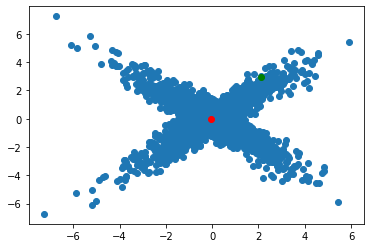

In [37]:
plt.scatter(*X2.T)
plt.scatter(*gmm.means_[0], color='red')
plt.scatter(*gmm.means_[1], color='green')


In [38]:
gmm.covariances_[0]

array([[ 2.94587130e+00, -9.43314460e-04],
       [-9.43314460e-04,  2.94641194e+00]])

In [39]:
gmm.covariances_[1]

array([[0.11382542, 0.01010075],
       [0.01010075, 0.04805508]])

In [40]:
gmm.predict(X2)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
gmm.predict_proba(X2)

array([[1.00000000e+00, 2.93150453e-29],
       [9.99999998e-01, 2.08398632e-09],
       [9.99992194e-01, 7.80611974e-06],
       ...,
       [1.00000000e+00, 3.47320297e-33],
       [1.00000000e+00, 5.83039626e-40],
       [1.00000000e+00, 1.72363694e-45]])

In [42]:
b = np.random.randn(1_000_000, 12)

In [43]:
%%time
mixture.GaussianMixture(n_components=12, n_init=1).fit(b)

Wall time: 1min 16s


GaussianMixture(n_components=12)

In [44]:
%%time
mixture.GaussianMixture(n_components=12, n_init=1, covariance_type='spherical').fit(b)

Wall time: 27.8 s


GaussianMixture(covariance_type='spherical', n_components=12)

In [45]:
%%time
kmeans = cluster.KMeans(n_clusters=12, n_init=1).fit(b)

Wall time: 18 s


In [46]:
gmm.score(X)

-18.017331115759166

In [47]:
gmm.predict([[4, 5]])

array([0], dtype=int64)

In [48]:
gmm.predict_proba([[4, 5]])

array([[1.00000000e+00, 1.41181646e-23]])